# Data Modeling

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from scipy.stats import chi2_contingency
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
import os, sys
from plotly import io as pio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [35]:
# Path needs to be added manually to read from another folder
path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname('__file__'), os.path.pardir, 'utils')))
if (not (path2add in sys.path)) :
    sys.path.append(path2add)

from ml import PredictionAccuracy, underSampleTraining, dataSplitter, roc, pre_rec, RandomForestBuilder

pio.renderers.default='notebook'

In [45]:
df = pd.read_parquet("../data/cleaned_data_engineered_feats.parquet")
data = pd.read_parquet("../data/cleaned_data_engineered_feats_SD.parquet")

In [46]:
df.head()

,Administrative_Duration,ProductRelated,BounceRates,PageValues,Revenue
0,0.0,1,0.20,0.0,0
1,0.0,2,0.00,0.0,0
2,0.0,1,0.20,0.0,0
3,0.0,2,0.05,0.0,0
4,0.0,10,0.02,0.0,0


In [47]:
data.head()

,Administrative_Duration,ProductRelated,BounceRates,PageValues,SpecialDay,Revenue
0,0.0,1,0.20,0.0,0,0
1,0.0,2,0.00,0.0,0,0
2,0.0,1,0.20,0.0,0,0
3,0.0,2,0.05,0.0,0,0
4,0.0,10,0.02,0.0,0,0


In [11]:
# Separating the target variable
Y = df["Revenue"]
X = df.drop(["Revenue"], axis=1)

In [14]:
# Split data to build RFC models and other ensemble methods using the data from feature selection

X_train, y_train, X_test, y_test, x_undersampled, y_undersampled = dataSplitter(X, Y, split=0.2, resample=True)

In [15]:
data_set_names = ['X_train', 'y_train', 'X_test', 'y_test', 'x_undersampled', 'y_undersampled']
split_data_sets = [X_train, y_train, X_test, y_test, x_undersampled, y_undersampled]

for i in range(len(data_set_names)):
    length = len(split_data_sets[i])
    print(data_set_names[i], 'length is:\t', length)

X_train length is:	 9864
y_train length is:	 9864
X_test length is:	 2466
y_test length is:	 2466
x_undersampled length is:	 2972
y_undersampled length is:	 2972


ACCURACY OF THE MODEL ON THE TRAIN SET:   0.9939172749391727
ACCURACY OF THE MODEL ON THE TEST SET:   0.8734793187347932


 Classification Report of Model on Testing Set
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      2152
           1       0.50      0.68      0.58       314

    accuracy                           0.87      2466
   macro avg       0.73      0.79      0.75      2466
weighted avg       0.89      0.87      0.88      2466


Precision-Recall curve area is:
0.6313435273834084


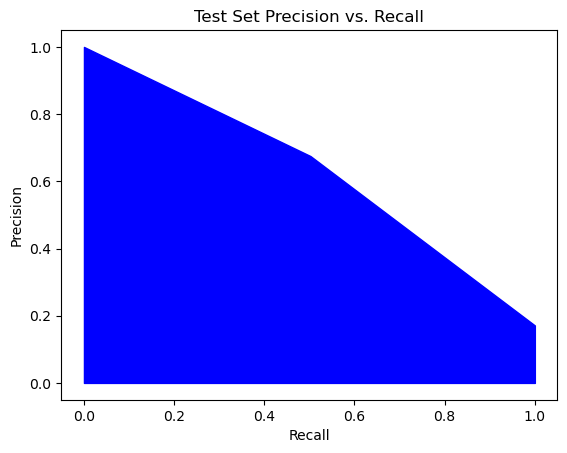

In [16]:
# Base Random Forest Model (uses default parameters and no under sampling)

# Random Forest Model with default paramaters
RF1, rfc_pred, RF1_PR_AUC = RandomForestBuilder(X_train, y_train, X_test, y_test)

AUC Score is:
0.7262337578022834


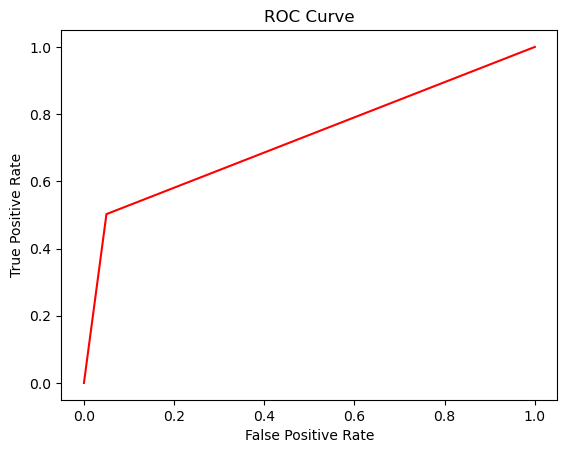

In [17]:
RF1_roc = roc(y_test, rfc_pred)
print(RF1_roc)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
ACCURACY OF THE MODEL ON THE TRAIN SET:   0.9535685320356854
ACCURACY OF THE MODEL ON THE TEST SET:   0.878345498783455


 Classification Report of Model on Testing Set
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      2156
           1       0.51      0.70      0.59       310

    accuracy                           0.88      2466
   macro avg       0.73      0.80      0.76      2466
weighted avg       0.90      0.88      0.89      2466


Precision-Recall curve area is:
0.6460793128079878


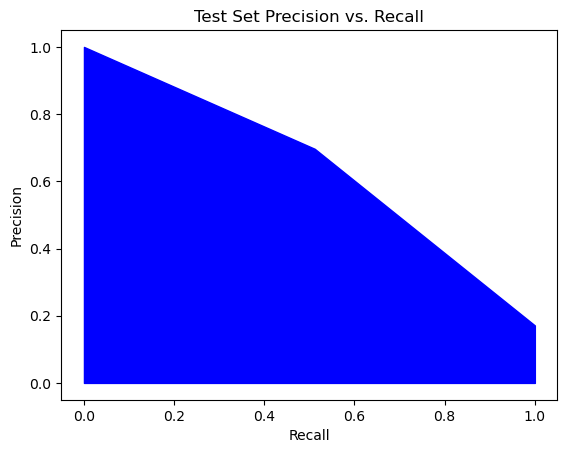

In [18]:
# Random Forest Model with parameter tuning
RF2, rfc_pred2, RF2_PR_AUC = RandomForestBuilder(X_train, y_train, X_test, y_test, CV=True)

AUC Score is:
0.732930041457601


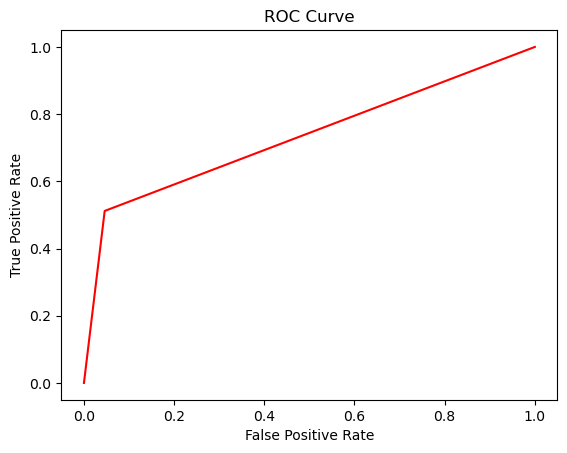

In [19]:
RF2_roc = roc(y_test, rfc_pred2)
print(RF2_roc)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
ACCURACY OF THE MODEL ON THE TRAIN SET:   0.9158815612382234
ACCURACY OF THE MODEL ON THE TEST SET:   0.8467153284671532


 Classification Report of Model on Testing Set
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1814
           1       0.82      0.53      0.65       652

    accuracy                           0.85      2466
   macro avg       0.84      0.75      0.78      2466
weighted avg       0.84      0.85      0.83      2466


Precision-Recall curve area is:
0.694197495675729


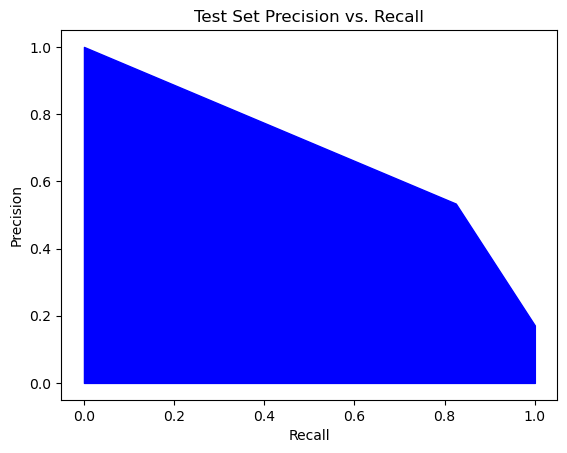

In [20]:
# Random Forest Model with under sampling and parameter tuning
RF3, rfc_pred3, RF3_PR_AUC = RandomForestBuilder(x_undersampled, y_undersampled, X_test, y_test, CV=True)

AUC Score is:
0.8379582827093053


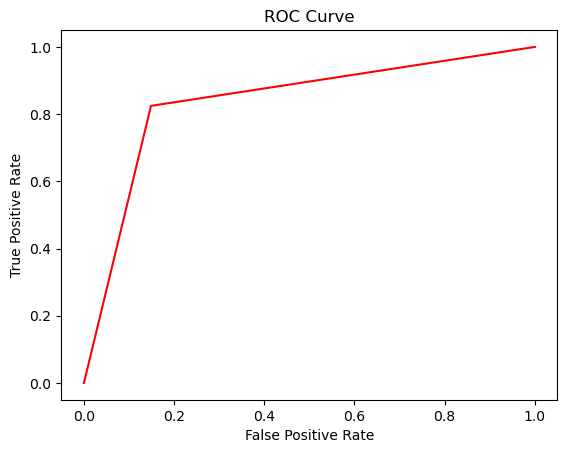

In [21]:
RF3_roc = roc(y_test, rfc_pred3)
print(RF3_roc)

**Observations:**
- Cross validation provides marginal improvement with respect to test accuracy and the F1 scores for both classes
- Under sampling on this data shows better model metrics than the models without under sampling with respect to training accuracy and F1 score for class 1
- The model using under sampling and cross validation had a larger F1 score for class 1 and a lower score for class 0
-The model with under sampling and cross validation had the largest area under the curve (AUC) for the precision-recall curve and the ROC curve, 0.84


## Exploring Random Forest and the SpecialDay Variable

One could imagine that online shopping behavior changes with proximity to a holiday or special day. Although SpecialDay was not an important feature included from feature selection using Gini, SpecialDay will be used to subset the data in order to understand the impact of using two separate random forest classifiers. Using cross-validation and under sampling, six models will be built to ascertain the impact on model performance.

In [48]:
data['SpecialDay'].value_counts()

SpecialDay
0    11079
1     1251
Name: count, dtype: int64

In [53]:
data = pd.get_dummies(data, columns=['SpecialDay'])

In [54]:
data.columns

Index(['Administrative_Duration', 'ProductRelated', 'BounceRates',
       'PageValues', 'Revenue', 'SpecialDay_0', 'SpecialDay_1'],
      dtype='object')

In [57]:
# split the 90% of the data not in the evaluation set by their value for special day
m = data['SpecialDay_1'] == 1
df_SD_true, df_SD_false = data[m], data[~m]

In [58]:
# drop special day variables from subsets
df_SD_true = df_SD_true.drop(["SpecialDay_1", "SpecialDay_0"], axis=1)

df_SD_false =  df_SD_false.drop(["SpecialDay_1", "SpecialDay_0"], axis=1)

In [60]:
# Separating the target variable
Y_SD_true = df_SD_true["Revenue"]
X_SD_true = df_SD_true.drop(["Revenue"], axis=1)


Y_SD_false = df_SD_false["Revenue"]
X_SD_false = df_SD_false.drop(["Revenue"], axis=1)

## Random Forest and SpecialDay = 1

In [61]:
# Split data to build models for comparison using the data from feature selection, subset by SpecialDay=1

X_train_SD_true, y_train_SD_true, X_test_SD_true, y_test_SD_true, x_undersampled_SD_true, y_undersampled_SD_true = \
    dataSplitter(X_SD_true, Y_SD_true, split=0.2, resample=True)

In [62]:
data_set_names = ['X_train_SD_true', 'y_train_SD_true', 'X_test_SD_true', 'y_test_SD_true', 'x_undersampled_SD_true', 'y_undersampled_SD_true']
split_data_sets = [X_train_SD_true, y_train_SD_true, X_test_SD_true, y_test_SD_true, x_undersampled_SD_true, y_undersampled_SD_true]

for i in range(len(data_set_names)):
    length = len(split_data_sets[i])
    print(data_set_names[i], 'length is:\t', length)

X_train_SD_true length is:	 1000
y_train_SD_true length is:	 1000
X_test_SD_true length is:	 251
y_test_SD_true length is:	 251
x_undersampled_SD_true length is:	 120
y_undersampled_SD_true length is:	 120


ACCURACY OF THE MODEL ON THE TRAIN SET:   1.0
ACCURACY OF THE MODEL ON THE TEST SET:   0.9721115537848606


 Classification Report of Model on Testing Set
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       235
           1       0.76      0.81      0.79        16

    accuracy                           0.97       251
   macro avg       0.88      0.90      0.89       251
weighted avg       0.97      0.97      0.97       251


Precision-Recall curve area is:
0.7965710686665104


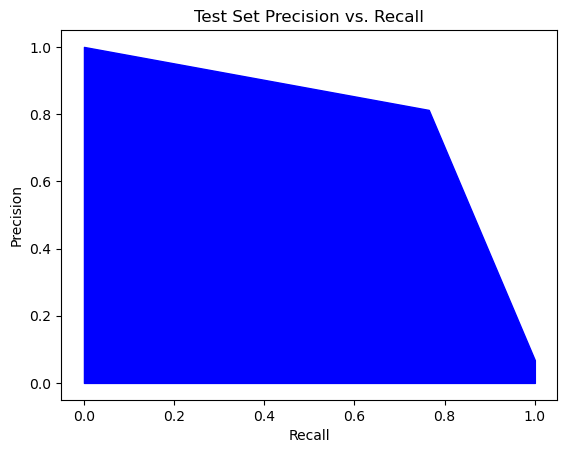

In [63]:
# Random Forest Model where SpecialDay=1
# Base model
RF1_SD1, rfc_pred_SD1_1, RF1_SD1_PR_AUC = RandomForestBuilder(X_train_SD_true, y_train_SD_true, X_test_SD_true, y_test_SD_true)

AUC Score is:
0.8759426847662142


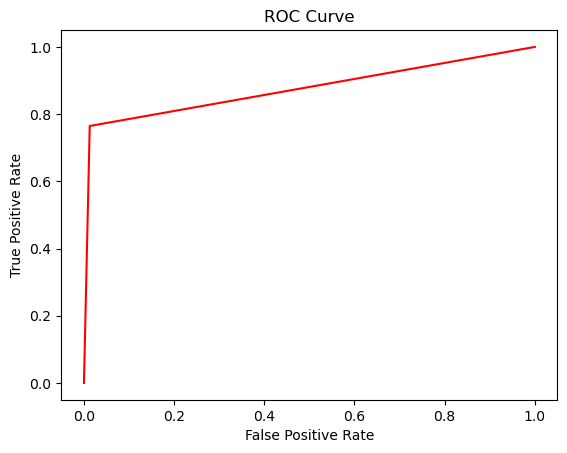

In [64]:
RF1_SD1_roc = roc(y_test_SD_true, rfc_pred_SD1_1)
print(RF1_SD1_roc)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
ACCURACY OF THE MODEL ON THE TRAIN SET:   1.0
ACCURACY OF THE MODEL ON THE TEST SET:   0.9681274900398407


 Classification Report of Model on Testing Set
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       236
           1       0.71      0.80      0.75        15

    accuracy                           0.97       251
   macro avg       0.85      0.89      0.87       251
weighted avg       0.97      0.97      0.97       251


Precision-Recall curve area is:
0.7629013358331381


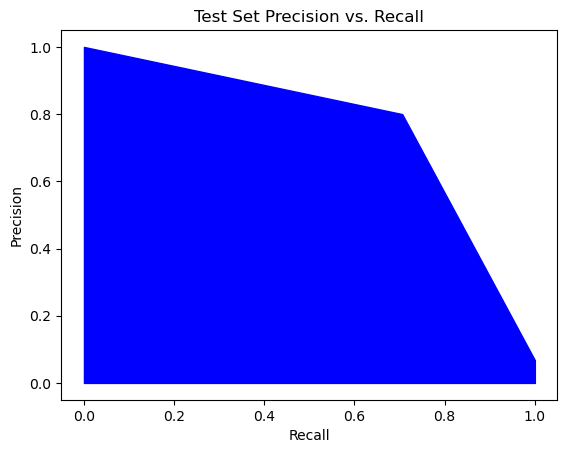

In [65]:
# Random Forest Model with parameter tuning where SpecialDay=1
RF2_SD1, rfc_pred_SD1_2, RF2_SD1_PR_AUC = RandomForestBuilder(X_train_SD_true, y_train_SD_true, X_test_SD_true, y_test_SD_true, CV=True)

AUC Score is:


0.8465309200603319

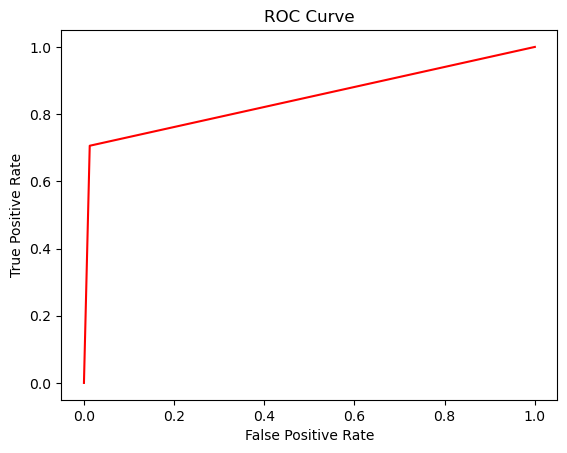

In [66]:
RF2_SD1_roc = roc(y_test_SD_true, rfc_pred_SD1_2)
RF2_SD1_roc

Fitting 5 folds for each of 50 candidates, totalling 250 fits
ACCURACY OF THE MODEL ON THE TRAIN SET:   1.0
ACCURACY OF THE MODEL ON THE TEST SET:   0.9282868525896414


 Classification Report of Model on Testing Set
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       216
           1       1.00      0.49      0.65        35

    accuracy                           0.93       251
   macro avg       0.96      0.74      0.81       251
weighted avg       0.93      0.93      0.92       251


Precision-Recall curve area is:
0.7428571428571429


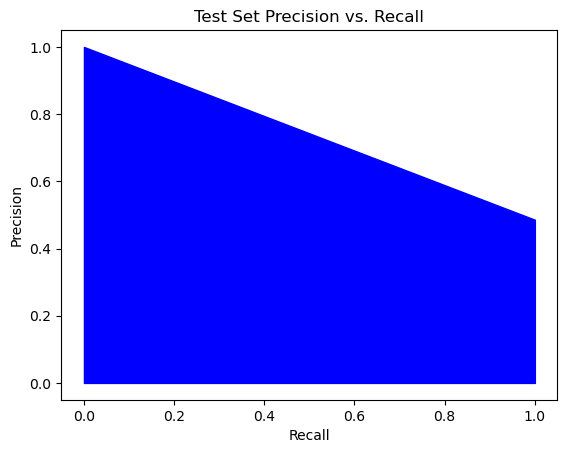

In [67]:
# Random Forest Model with under sampling and parameter tuning where SpecialDay=1
RF3_SD1, rfc_pred_SD1_3, RF3_SD1_PR_AUC = RandomForestBuilder(x_undersampled_SD_true, y_undersampled_SD_true, X_test_SD_true, y_test_SD_true, CV=True)

AUC Score is:


0.9615384615384616

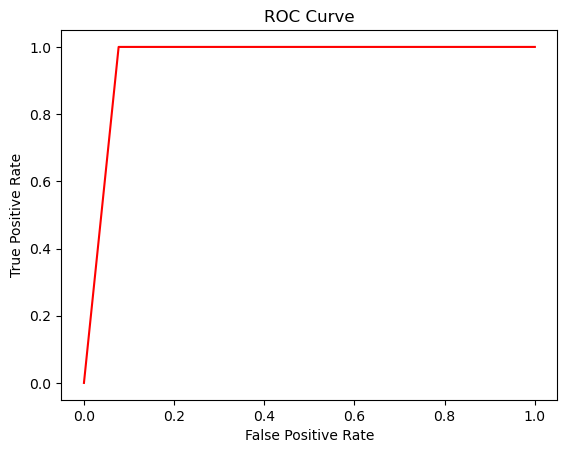

In [68]:
RF3_SD1_roc = roc(y_test_SD_true, rfc_pred_SD1_3)
RF3_SD1_roc

**Observations:**
- The models that were not trained on under sampled data had higher test accuracies, F1 scores, and precision-recall curve AUC, but they had lower ROC AUC scores
- The model built with under sampling had a lower test accuracy o
- The models built without under sampling had much larger F1 scores for class 1
- Compared to the models that were built on the data not subset by SpecialDay, these models performed much better across multiple metrics, including approximately 10% higher test accuracy and approximately 0.06-0.2 higher F1 scores for both classes. It is possible that the limited testing set size contributed to the increased performance (n=251)

## Random Forest and SpecialDay = 0

In [69]:
# Split data to build models for comparison using the data from feature selection, subset by SpecialDay=0

X_train_SD_false, y_train_SD_false, X_test_SD_false, y_test_SD_false, x_undersampled_SD_false, y_undersampled_SD_false = \
    dataSplitter(X_SD_false, Y_SD_false, split=0.2, resample=True)

In [70]:
data_set_names = ['X_train_SD_false', 'y_train_SD_false', 'X_test_SD_false', 'y_test_SD_false', 'x_undersampled_SD_false', 'y_undersampled_SD_false']
split_data_sets = [X_train_SD_false, y_train_SD_false, X_test_SD_false, y_test_SD_false, x_undersampled_SD_false, y_undersampled_SD_false]

for i in range(len(data_set_names)):
    length = len(split_data_sets[i])
    print(data_set_names[i], 'length is:\t', length)

X_train_SD_false length is:	 8863
y_train_SD_false length is:	 8863
X_test_SD_false length is:	 2216
y_test_SD_false length is:	 2216
x_undersampled_SD_false length is:	 2886
y_undersampled_SD_false length is:	 2886


ACCURACY OF THE MODEL ON THE TRAIN SET:   0.9935687690398285
ACCURACY OF THE MODEL ON THE TEST SET:   0.8763537906137184


 Classification Report of Model on Testing Set
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      1896
           1       0.56      0.68      0.61       320

    accuracy                           0.88      2216
   macro avg       0.75      0.79      0.77      2216
weighted avg       0.89      0.88      0.88      2216


Precision-Recall curve area is:
0.6572847077487067


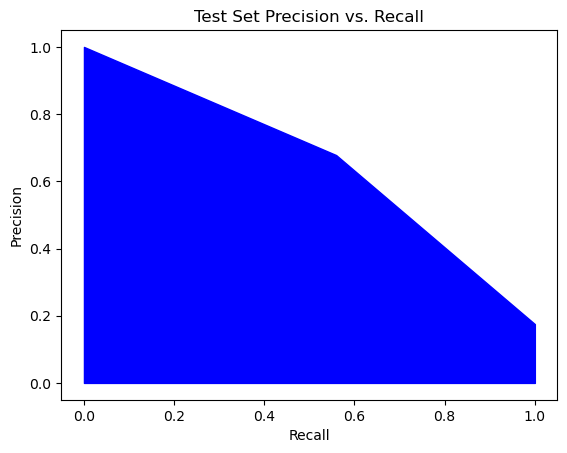

In [71]:
# Random Forest Model where SpecialDay=0
# Base model

RF1_SD0, rfc_pred_SD0_1, RF1_SD0_PR_AUC = RandomForestBuilder(X_train_SD_false, y_train_SD_false, X_test_SD_false, y_test_SD_false)

AUC Score is:
0.7514663087369442


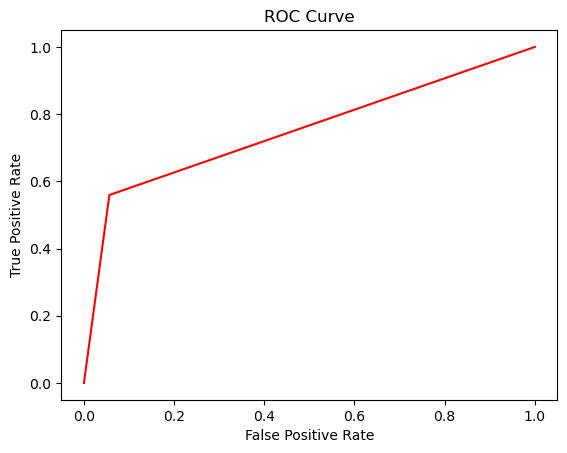

In [72]:
RF1_SD0_roc = roc(y_test_SD_false, rfc_pred_SD0_1)
print(RF1_SD0_roc)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
ACCURACY OF THE MODEL ON THE TRAIN SET:   0.9479860092519463
ACCURACY OF THE MODEL ON THE TEST SET:   0.8795126353790613


 Classification Report of Model on Testing Set
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1913
           1       0.55      0.70      0.61       303

    accuracy                           0.88      2216
   macro avg       0.75      0.80      0.77      2216
weighted avg       0.90      0.88      0.89      2216


Precision-Recall curve area is:
0.6627420511227498


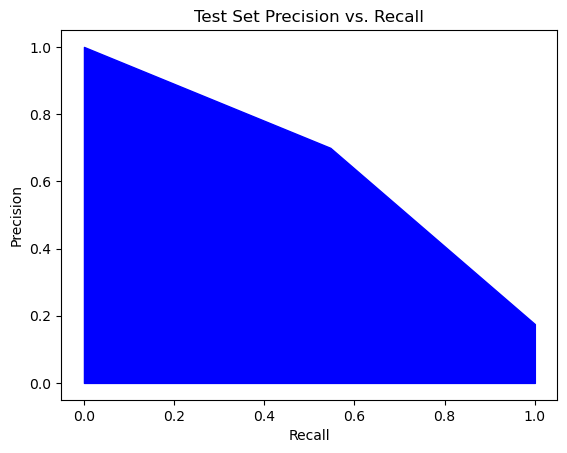

In [73]:
# Random Forest Model with parameter tuning where SpecialDay=0
RF2_SD0, rfc_pred_SD0_2, RF2_SD0_PR_AUC = RandomForestBuilder(X_train_SD_false, y_train_SD_false, X_test_SD_false, y_test_SD_false, CV=True)

AUC Score is:
0.7483052854790317


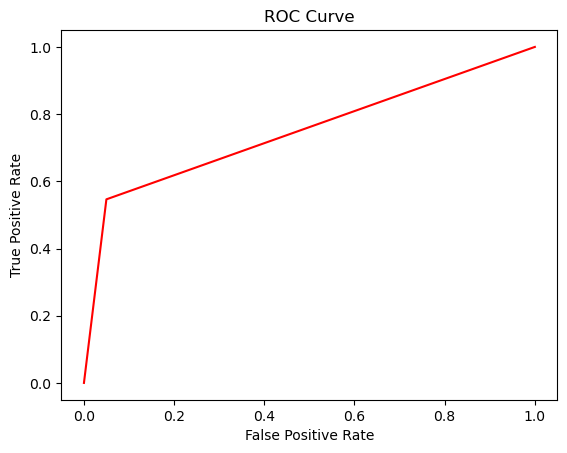

In [74]:
RF2_SD0_roc = roc(y_test_SD_false, rfc_pred_SD0_2)
print(RF2_SD0_roc)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
ACCURACY OF THE MODEL ON THE TRAIN SET:   0.9092169092169092
ACCURACY OF THE MODEL ON THE TEST SET:   0.8388989169675091


 Classification Report of Model on Testing Set
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      1605
           1       0.83      0.53      0.64       611

    accuracy                           0.84      2216
   macro avg       0.83      0.74      0.77      2216
weighted avg       0.84      0.84      0.83      2216


Precision-Recall curve area is:
0.6914612467205407


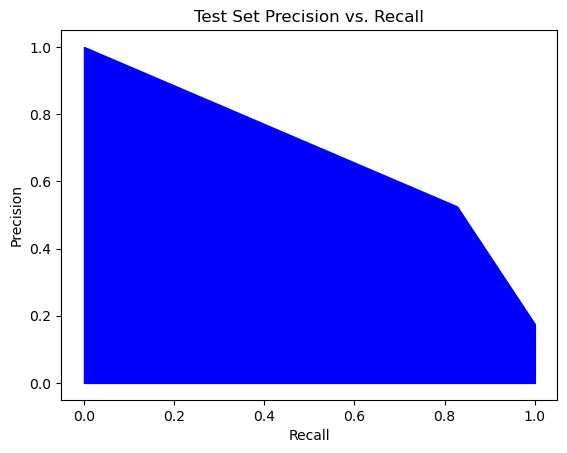

In [75]:
# Random Forest Model with under sampling and parameter tuning where SpecialDay=0
RF3_SD0, rfc_pred_SD0_3, RF3_SD0_PR_AUC = RandomForestBuilder(x_undersampled_SD_false, y_undersampled_SD_false, X_test_SD_false, y_test_SD_false, CV=True)

AUC Score is:
0.8343381307947393


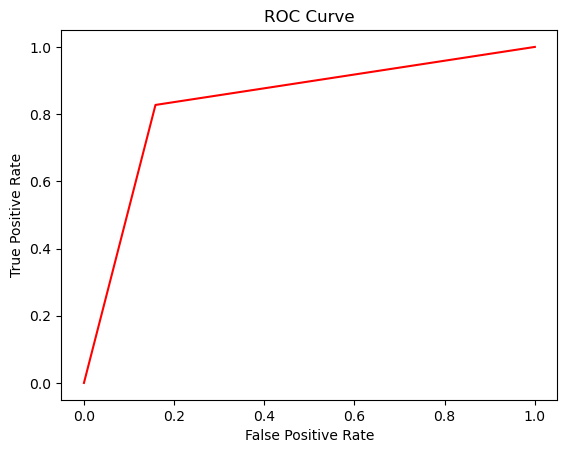

In [76]:
RF3_SD0_roc = roc(y_test_SD_false, rfc_pred_SD0_3)
print(RF3_SD0_roc)

**Observations:**
- The models trained on the under sampled data sets had a lower test accuracy 
- All the models had fairly comparable F1 scores for both classes
- The model that utilized under sampling had much larger precision for class 1 than both of the other two models
- The model built with under sampling had higher ROC AUC scores than those built without
- Compared to the models that were built on the data not subset by SpecialDay, these models performed similarly across multiple metrics

In [77]:
pr_curve_AUC = [RF1_PR_AUC, RF2_PR_AUC, RF3_PR_AUC, 0, RF1_SD1_PR_AUC, RF2_SD1_PR_AUC, RF3_SD1_PR_AUC,0, RF1_SD0_PR_AUC, RF2_SD0_PR_AUC, RF3_SD0_PR_AUC]

ROC_AUC = [RF1_roc, RF2_roc, RF3_roc,0, RF1_SD1_roc, RF2_SD1_roc, RF3_SD1_roc,0, RF1_SD0_roc, RF2_SD0_roc, RF3_SD0_roc]

rfc_models = ['Base Model', 'CV', 'CV,\nUnder Sampling', '',
              'SD=1 Model', 'SD=1 CV', 'SD=1 CV,\nUnder Sampling','',
             'SD=0 Model', 'SD=0 CV', 'SD=0 CV,\nUnder Sampling']

In [ ]:
# create vars for simplified graph

pr_simplified = [pr_curve_AUC[i] for i in [2,6,10]]
roc_simplified = [ROC_AUC[i] for i in [2,6,10]]
models_simplified = [rfc_models[i] for i in [2,6,10]]

In [ ]:
# Width of each bar
bar_width = 0.4

# Index for the x-axis
index = np.arange(len(models_simplified))

# Plotting the grouped bar chart
fig, ax = plt.subplots(figsize=(15, 6))
bar1 = ax.bar(index, pr_simplified, bar_width, label='Precision-Recall Curve AUC',color='blue')
bar2 = ax.bar(index + bar_width, roc_simplified, bar_width, label='ROC AUC',color='green')

# Adding labels and title
ax.set_xlabel('\nModel')
ax.set_ylabel('Value')
ax.set_title('Random Forest Model AUC')

ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models_simplified)
ax.set_ylim(0, 1.2) 


# Add score on top of each bar
for bar in bar1 + bar2:
    yval = bar.get_height()
    if yval != 0:
        ax.text(bar.get_x() + bar.get_width()/2.5, yval, round(yval, 2), va='bottom')

# Show plot and legend
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

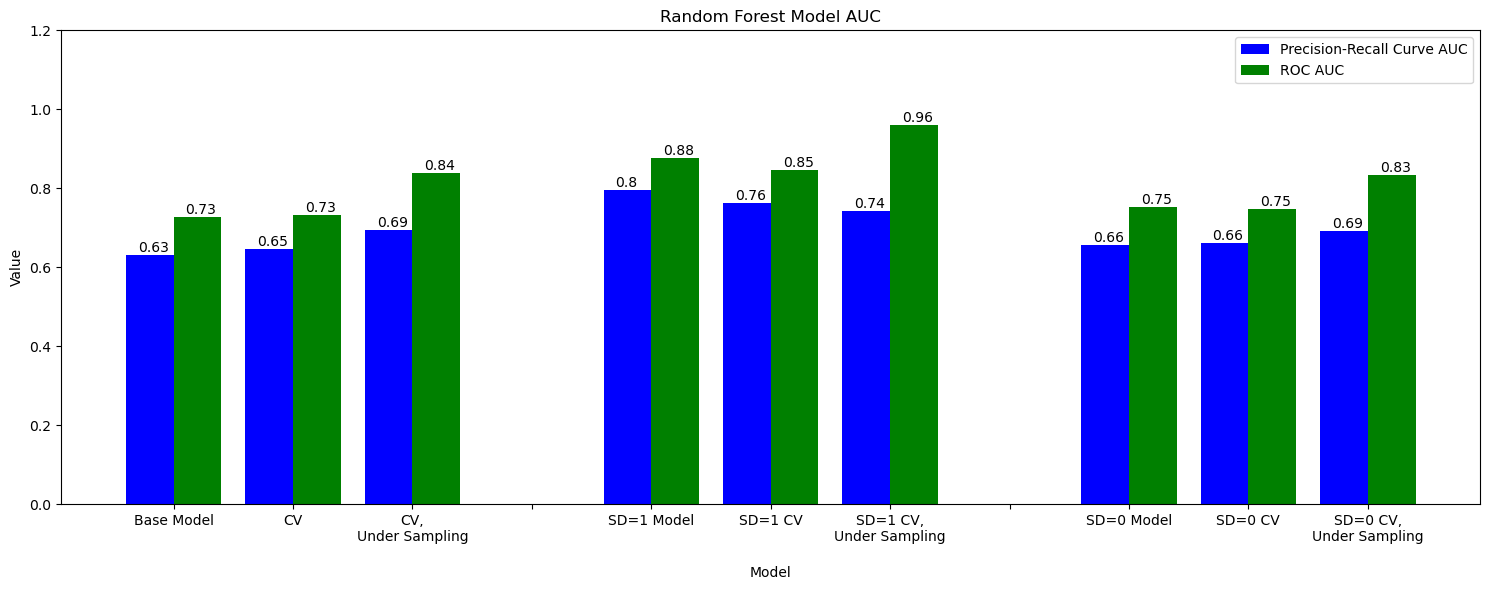

In [82]:
# graph of all models

# Width of each bar
bar_width = 0.4

# Index for the x-axis
index = np.arange(len(rfc_models))

# Plotting the grouped bar chart
fig, ax = plt.subplots(figsize=(15, 6))
bar1 = ax.bar(index, pr_curve_AUC, bar_width, label='Precision-Recall Curve AUC',color='blue')
bar2 = ax.bar(index + bar_width, ROC_AUC, bar_width, label='ROC AUC',color='green')

# Adding labels and title
ax.set_xlabel('\nModel')
ax.set_ylabel('Value')
ax.set_title('Random Forest Model AUC')

ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(rfc_models)
ax.set_ylim(0, 1.2) 


# Add score on top of each bar
for bar in bar1 + bar2:
    yval = bar.get_height()
    if yval != 0:
        ax.text(bar.get_x() + bar.get_width()/4, yval, round(yval, 2), va='bottom')

# Show plot and legend
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Summary

- Taking subsets of the data by SpecialDay showed improved model performance across the key performance metrics for class 1 (a sale). Additional data may be needed to determine if this finding holds. 